# Part 2: CNN Classification

## Introduction

In this part, you'll implement a Convolutional Neural Network (CNN) for EMNIST character recognition. You can choose between TensorFlow/Keras or PyTorch for implementation. This will help you understand CNNs and their advantages for image classification tasks.

## Learning Objectives

- Implement a CNN using either TensorFlow/Keras or PyTorch
- Apply convolutional layers, pooling, and batch normalization
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [ ]:
# Install required packages
#%pip install -r .github/tests/requirements.txt

In [3]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)

## 1. Data Loading and Preprocessing

Training data shape: (88800, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)
Number of classes: 26


2025-05-26 19:02:06.622502: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


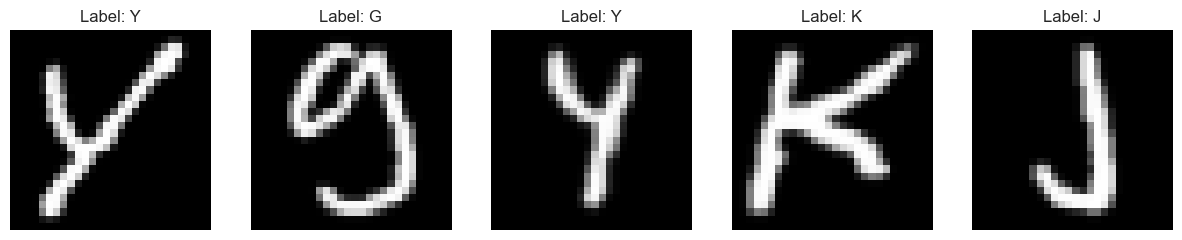

In [7]:
import tensorflow_datasets as tfds

# Load EMNIST dataset
ds_train, ds_test = tfds.load('emnist/letters', split=['train', 'test'], as_supervised=True)

# Convert to numpy arrays
x_train = np.array([x.numpy() for x, y in ds_train])
y_train = np.array([y.numpy() for x, y in ds_train])
x_test = np.array([x.numpy() for x, y in ds_test])
y_test = np.array([y.numpy() for x, y in ds_test])

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(x_train[i].squeeze()), cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()

In [8]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input (samples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (71040, 28, 28, 1)
Preprocessed validation data shape: (17760, 28, 28, 1)
Preprocessed test data shape: (14800, 28, 28, 1)


## 2. Model Implementation
### TensorFlow/Keras Implementation

In [13]:
from keras import layers

# Create CNN using Keras
def create_cnn_keras(input_shape, num_classes):
    """
    Create a CNN using TensorFlow/Keras.
    
    Requirements:
    - Must use at least 2 convolutional layers
    - Must include pooling and batch normalization
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 85% accuracy on test set
    - Minimize overfitting using batch normalization and dropout
    - Train efficiently with appropriate batch size and learning rate
    
    Args:
        input_shape: Shape of input data (should be (28, 28, 1) for grayscale images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
    
    return model

# Create and compile model
model_tf = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)
model_tf.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 227,994 (890.60 KB)

 Trainable params: 227,546 (888.85 KB)

 Non-trainable params: 448 (1.75 KB)

### PyTorch Implementation

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        """
        Create a CNN using PyTorch.
        
        Requirements:
        - Must use at least 2 convolutional layers
        - Must include pooling and batch normalization
        
        Goals:
        - Achieve > 85% accuracy on test set
        - Minimize overfitting using batch normalization and dropout
        - Train efficiently with appropriate batch size and learning rate
        
        Args:
            num_classes: Number of output classes (26 for letters)
        """
        super(CNN, self).__init__()
        
        # 1st conv module
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 2nd conv module
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 3rd conv module
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # flatten layer
        self.flatten = nn.Flatten()  
        
        # fully connected layer module
        self.fc = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),  
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        """
        Forward pass of the network.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
        
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        # fix mismatched dimensions
        if x.dim() == 4 and x.shape[1] != 1:
            x = x.permute(0, 3, 1, 2)

        # 1st conv block
        x = self.layer1(x)

        # 2nd conv block
        x = self.layer2(x)

        # 3rd conv block
        x = self.layer3(x)

        # flatten layer
        x = self.flatten(x) 

        # fully connected layers
        x = self.fc(x)

        return x

# Create model
model_cnn = CNN(num_classes=26)
print(model_cnn)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(

## 3. Training and Evaluation

### TensorFlow/Keras Training

Epoch 1/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.5986 - loss: 1.4144 - val_accuracy: 0.8863 - val_loss: 0.3680 - learning_rate: 0.0010
Epoch 2/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.8264 - loss: 0.5446 - val_accuracy: 0.9046 - val_loss: 0.2842 - learning_rate: 0.0010
Epoch 3/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.8546 - loss: 0.4503 - val_accuracy: 0.9164 - val_loss: 0.2502 - learning_rate: 0.0010
Epoch 4/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.8674 - loss: 0.4066 - val_accuracy: 0.9171 - val_loss: 0.2463 - learning_rate: 0.0010
Epoch 5/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.8755 - loss: 0.3793 - val_accuracy: 0.9255 - val_loss: 0.2210 - learning_rate: 0.0010
Epoch 6/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.8830 - loss: 0.3527 - val_accuracy: 0.9283 - val_loss: 0.2105 - learning_rate: 0.0010
Epoch 7/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accura

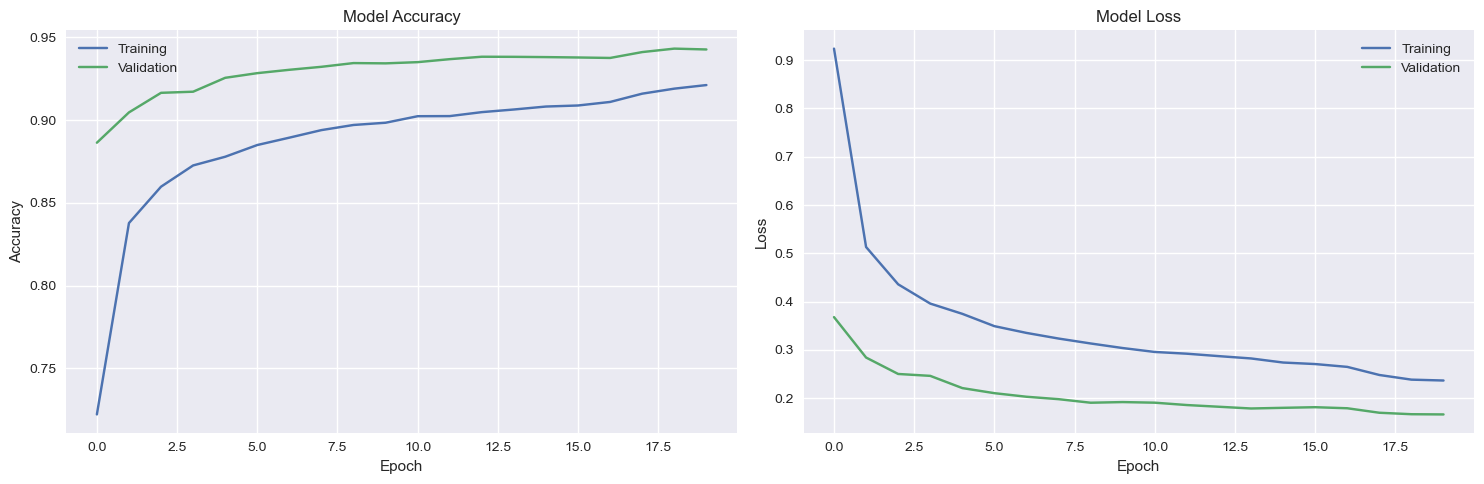

In [15]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]

# Train model
history = model_tf.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### PyTorch Training

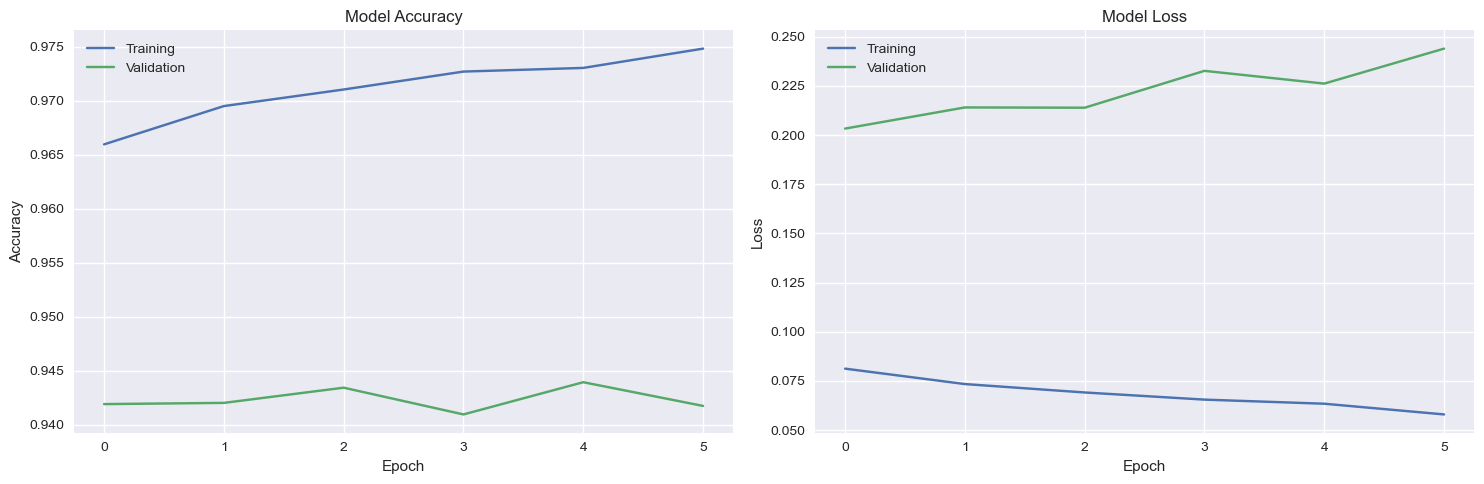

In [23]:
from torch.utils.data import DataLoader, TensorDataset

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cnn = model_cnn.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters())

# Convert data to PyTorch tensors
x_train = torch.FloatTensor(x_train).to(device)
y_train = y_train.to(device)  
x_val = torch.FloatTensor(x_val).to(device)
y_val = y_val.to(device)

# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
patience = 5
patience_counter = 0

# use dataloader for faster performance
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(20):
    # Training
    model_cnn.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for i in range(0, len(x_train), 32):
        batch_x = x_train[i:i+32]
        batch_y = y_train[i:i+32]
        
        optimizer.zero_grad()
        outputs = model_cnn(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += batch_y.size(0)
        train_correct += predicted.eq(batch_y).sum().item()
    
    train_loss = train_loss / (len(x_train) / 32)
    train_acc = train_correct / train_total
    
    # Validation
    model_cnn.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for i in range(0, len(x_val), 32):
            batch_x = x_val[i:i+32]
            batch_y = y_val[i:i+32]
            
            outputs = model_cnn(batch_x)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += batch_y.size(0)
            val_correct += predicted.eq(batch_y).sum().item()
    
    val_loss = val_loss / (len(x_val) / 32)
    val_acc = val_correct / val_total
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model_cnn.state_dict(), 'models/cnn_pytorch.pt')
        # Save architecture
        with open('models/cnn_pytorch_arch.txt', 'w') as f:
            f.write(str(model_cnn))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history['train_acc'], label='Training')
ax1.plot(history['val_acc'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history['train_loss'], label='Training')
ax2.plot(history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()